In [1]:
import torch
import torch.utils
import torch.utils.data
from tqdm.auto import tqdm
from torch import nn
import argparse
import torch.nn.functional as F
import utils
import dataset
import os
import matplotlib.pyplot as plt

/Users/kshitijvaidya/miniconda3/envs/cs726env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np

dataPath = 'data/albatross.npy'
data = np.load(dataPath)
print(data.shape)

(32561, 16, 4)


In [3]:
dataPath2 = 'data/albatross_prior_samples.npy'
data2 = np.load(dataPath2)
print(data2.shape)

(32561, 64)


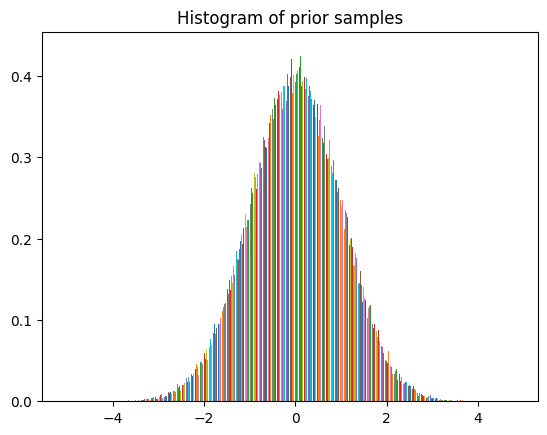

In [4]:
# Make a histogram of the prior sample data
plt.hist(data2, bins=100, density=True)
plt.title('Histogram of prior samples')
plt.show()

In [5]:
moonDataX, moonDataY = dataset.load_dataset('moons')
print(type(moonDataX))
print(moonDataX.shape)
print(type(moonDataY))
print(moonDataY.shape)

<class 'torch.Tensor'>
torch.Size([8000, 2])
<class 'torch.Tensor'>
torch.Size([8000])


In [6]:
# Define the time embedding class to generate sinusoidal embeddings
class TimeEmbedding(nn.Module):
    def __init__(self, numDim : int):
        super().__init__()
        self.numDim = numDim

    def forward(self, time : torch.Tensor):
        '''
        Input:
            time: (batchSize, 1)
        Output:
            embedding: (batchSize, numDim)
        '''
        # Generate the sinusoidal embeddings
        embedding = torch.zeros(time.shape[0], self.numDim)
        for i in range(self.numDim):
            if i % 2 == 0:
                embedding[:, i] = torch.sin(time / 10000 ** (i / self.numDim))
            else:
                embedding[:, i] = torch.cos(time / 10000 ** ((i - 1) / self.numDim))
        return embedding


In [7]:
# Test the time embedding class to generate sinusoidal embeddings
timeEmbedding = TimeEmbedding(10)
timeSteps = torch.arange(0, 100)
print(timeSteps.shape)
embeddings = timeEmbedding(timeSteps)
print(embeddings.shape)
print(embeddings[2, :])

torch.Size([100])
torch.Size([100, 10])
tensor([ 0.9093, -0.4161,  0.3117,  0.9502,  0.0502,  0.9987,  0.0080,  1.0000,
         0.0013,  1.0000])


In [8]:
# Write the Noise Scheduler class that will be used for training the DDPM Model
class NoiseScheduler():
    """
    Noise scheduler for the DDPM model

    Args:
        num_timesteps: int, the number of timesteps
        type: str, the type of scheduler to use
        **kwargs: additional arguments for the scheduler

    This object sets up all the constants like alpha, beta, sigma, etc. required for the DDPM model
    
    """
    def __init__(self, num_timesteps=50, type="linear", **kwargs):

        self.num_timesteps = num_timesteps
        self.type = type

        if type == "linear":
            self.init_linear_schedule(**kwargs)
        else:
            raise NotImplementedError(f"{type} scheduler is not implemented") # change this if you implement additional schedulers


    def init_linear_schedule(self, beta_start, beta_end):
        """
        Precompute whatever quantities are required for training and sampling
        """
        self.betaSchedule = torch.linspace(beta_start, beta_end, self.num_timesteps)
        self.alpha = 1 - self.betaSchedule
        self.alphaProd = torch.cumprod(self.alpha, 0)
        self.sqrtCumprodAlpha = np.sqrt(self.alphaProd)
        self.sqrtAlpha = np.sqrt(self.alpha)
        self.sqrtOneMinusAlpha = np.sqrt(1 - self.alpha)
        self.sqrtOneMinusAlphaProd = torch.sqrt(1 - self.alphaProd)

    def __len__(self):
        return self.num_timesteps

In [9]:
noiseScheduler = NoiseScheduler(num_timesteps=50, 
                                type="linear", 
                                beta_start=0.0, 
                                beta_end=1.0)
# print(noiseScheduler.betaSchedule)
print(noiseScheduler.alpha)

tensor([1.0000, 0.9796, 0.9592, 0.9388, 0.9184, 0.8980, 0.8776, 0.8571, 0.8367,
        0.8163, 0.7959, 0.7755, 0.7551, 0.7347, 0.7143, 0.6939, 0.6735, 0.6531,
        0.6327, 0.6122, 0.5918, 0.5714, 0.5510, 0.5306, 0.5102, 0.4898, 0.4694,
        0.4490, 0.4286, 0.4082, 0.3878, 0.3673, 0.3469, 0.3265, 0.3061, 0.2857,
        0.2653, 0.2449, 0.2245, 0.2041, 0.1837, 0.1633, 0.1429, 0.1224, 0.1020,
        0.0816, 0.0612, 0.0408, 0.0204, 0.0000])


In [10]:
class MLPModel(nn.Module):
    def __init__(self, inputDim : int, timeEmbedDim : int, hiddenDim : int = 128):
        super().__init__()
        self.inputDim = inputDim
        self.timeEmbedDim = timeEmbedDim
        self.hiddenDim = hiddenDim
        self.fc1 = nn.Linear(inputDim + timeEmbedDim, hiddenDim)
        self.fc2 = nn.Linear(hiddenDim, hiddenDim)
        self.fc3 = nn.Linear(hiddenDim, inputDim)
        self.activation = nn.ReLU()
    
    def forward(self, input : torch.Tensor) -> torch.Tensor:
        '''
        Input:
            input: (batchSize, inputDim)
        Output:
            output: (batchSize, inputDim)
        '''
        output = self.fc1(input)
        output = self.activation(output)
        output = self.fc2(output)
        output = self.activation(output)
        output = self.fc3(output)
        return output


In [11]:
class DDPM(nn.Module):
    def __init__(self, n_dim=3, n_steps=200):
        """
        Noise prediction network for the DDPM

        Args:
            n_dim: int, the dimensionality of the data
            n_steps: int, the number of steps in the diffusion process
        We have separate learnable modules for `time_embed` and `model`. `time_embed` can be learned or a fixed function as well

        """
        super().__init__()
        self.n_dim = n_dim
        self.n_steps = n_steps
        self.time_embed_dim = n_dim
        self.time_embed = TimeEmbedding(self.time_embed_dim)
        self.model = MLPModel(n_dim, self.time_embed_dim)

    def forward(self, x, t):
        """
        Args:
            x: torch.Tensor, the input data tensor [batch_size, n_dim]
            t: torch.Tensor, the timestep tensor [batch_size]

        Returns:
            torch.Tensor, the predicted noise tensor [batch_size, n_dim]
        """
        # Get the time embeddings
        timeEmbeddings = self.time_embed(t)
        # Concatenate the input data with the time embeddings
        input = torch.cat([x, timeEmbeddings], dim=-1)
        # Get the predicted noise
        noise = self.model(input)
        return noise

In [12]:
# Define a test model
ddpm = DDPM(n_dim=3, n_steps=200)
x = torch.randn(10, 3)
t = torch.randint(0, 200, (10,))
print(x.shape)
print(t.shape)
output = ddpm(x, t)
print(output.shape)

torch.Size([10, 3])
torch.Size([10])
torch.Size([10, 3])


In [ ]:
def train(model, noise_scheduler, dataloader, optimizer, epochs, run_name):
    """
    Train the model and save the model and necessary plots

    Args:
        model: DDPM, model to train
        noise_scheduler: NoiseScheduler, scheduler for the noise
        dataloader: torch.utils.data.DataLoader, dataloader for the dataset
        optimizer: torch.optim.Optimizer, optimizer to use
        epochs: int, number of epochs to train the model
        run_name: str, path to save the model
    """
    model.train()
    lossFunction = nn.MSELoss()
    device = next(model.parameters()).device
    for epoch in range(epochs):
        epochLoss = 0
        for x in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            x = x.to(device)
            # Define the random time step
            timesteps = torch.randint(1, noise_scheduler.num_timesteps, 
                                      (x.shape[0],), device=device)
            # Get the noise
            noise = torch.randn_like(x)
            noisyInput = (noise_scheduler.sqrtCumprodAlpha[timesteps, None] * x 
                          + noise_scheduler.sqrtOneMinusAlphaProd[timesteps, None] * noise)
            optimizer.zero_grad()
            predictedNoise = model(noisyInput, timesteps)
            loss = lossFunction(predictedNoise, noise)
            loss.backward()
            optimizer.step()
            epochLoss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} Loss: {epochLoss/len(dataloader)}")
    torch.save(model.state_dict(), f'models/{run_name}.pth')

In [14]:
print(moonDataX.shape)

torch.Size([8000, 2])


In [15]:
# Define the dataset and dataloader
batchSize = 64
n_steps = 200
dataset = moonDataX
n_dim = dataset.shape[1]
dataloader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batchSize, 
                                         shuffle=True)
# Define the model
ddpm = DDPM(n_dim=n_dim, n_steps=n_steps)
# Define the optimizer
optimizer = torch.optim.Adam(ddpm.parameters(), lr=1e-3)
# Train the model
train(ddpm, noiseScheduler, 
      dataloader, optimizer, epochs=10, 
      run_name="moon_test1")

Epoch 1/10: 100%|██████████| 125/125 [00:00<00:00, 403.52it/s]


Epoch 1/10 Loss: 0.2013234297633171


Epoch 2/10: 100%|██████████| 125/125 [00:00<00:00, 499.45it/s]


Epoch 2/10 Loss: 0.1343212428689003


Epoch 3/10: 100%|██████████| 125/125 [00:00<00:00, 497.36it/s]


Epoch 3/10 Loss: 0.1221363232433796


Epoch 4/10: 100%|██████████| 125/125 [00:00<00:00, 498.87it/s]


Epoch 4/10 Loss: 0.1171347684264183


Epoch 5/10: 100%|██████████| 125/125 [00:00<00:00, 498.87it/s]


Epoch 5/10 Loss: 0.12734159258008004


Epoch 6/10: 100%|██████████| 125/125 [00:00<00:00, 500.79it/s]


Epoch 6/10 Loss: 0.13045124006271364


Epoch 7/10: 100%|██████████| 125/125 [00:00<00:00, 499.99it/s]


Epoch 7/10 Loss: 0.12916688296198844


Epoch 8/10: 100%|██████████| 125/125 [00:00<00:00, 500.73it/s]


Epoch 8/10 Loss: 0.12589249369502067


Epoch 9/10: 100%|██████████| 125/125 [00:00<00:00, 497.92it/s]


Epoch 9/10 Loss: 0.13493049019575118


Epoch 10/10: 100%|██████████| 125/125 [00:00<00:00, 501.69it/s]

Epoch 10/10 Loss: 0.13090104830265045


In [ ]:
@torch.no_grad()
def sample(model, n_samples, noise_scheduler, return_intermediate=False):
    """
    Sample from the model
    
    Args:
        model: DDPM
        n_samples: int
        noise_scheduler: NoiseScheduler
        return_intermediate: bool
    Returns:
        torch.Tensor, samples from the model [n_samples, n_dim]

    If `return_intermediate` is `False`,
            torch.Tensor, samples from the model [n_samples, n_dim]
    Else
        the function returns all the intermediate steps in the diffusion process as well 
        Return: [[n_samples, n_dim]] x n_steps
        Optionally implement return_intermediate=True, will aid in visualizing the intermediate steps
    """  
    device = next(model.parameters()).device
    model.eval()
    samples = [] if return_intermediate else None
    numDim = model.model.inputDim
    inputs = torch.randn(n_samples, numDim, device=device)

    for timestep in reversed(range(1, noise_scheduler.num_timesteps + 1)):
        timesteps = torch.full((n_samples,), timestep, device=device)
        noisePred = model(inputs, timesteps)
        inputs = ((inputs - ((1.0 - noise_scheduler.alpha[timestep]) / noise_scheduler.sqrtOneMinusAlphaProd[timestep]) * noisePred)
                  / noise_scheduler.sqrtAlpha[timestep])
        if return_intermediate:
            samples.append(inputs.clone().cpu().numpy())
    if return_intermediate:
        return samples
    return inputs

    

In [19]:
# Test the sampling function
trainedModel = DDPM(n_dim=2, n_steps=200)
trainedModel.load_state_dict(torch.load('models/moon_test1.pth'))
# trainedModel.eval()
samples = sample(trainedModel, 1000, noiseScheduler, 
                 return_intermediate=True)
# print(samples.shape)

50


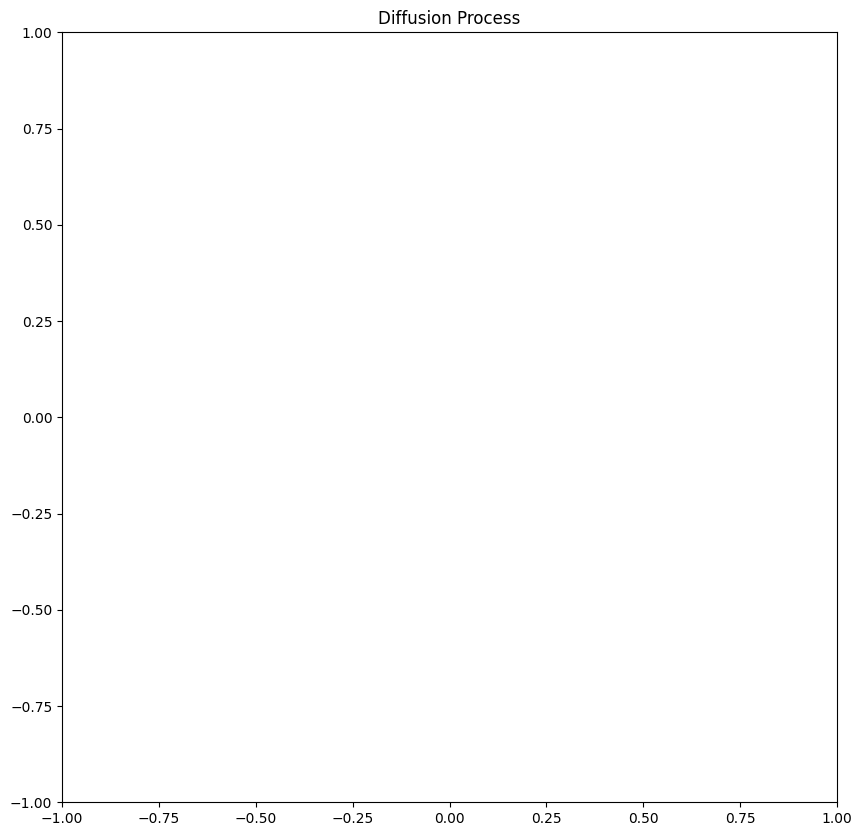

In [21]:
print(len(samples))
from utils import animateScatter2d

figure, axes = plt.subplots(1, 1, figsize=(10, 10))
animateScatter2d(figure, axes, samples, title="Diffusion Process")

In [22]:
print(samples[0])

[[ inf  inf]
 [-inf -inf]
 [ inf  inf]
 ...
 [ inf -inf]
 [-inf -inf]
 [ inf -inf]]
